In [148]:
import pandas as pd
import openpyxl
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sn
import re

df = pd.read_excel("/content/Daily Gen pdpu-From-1-01-2021.xlsx",None)  

In [149]:
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Extracting Time and Issue

In [150]:
pattern = "\d{2}\-\d{2}|\d{2}\.\d{2}|\d{2}\:\d{2}"

In [151]:
label_dict_1 = { 
    "Module Cleaning" : [["Module Cleaning"], ["No Module Cleaning"]],
    "Rainy day" : [["Rainy"], []] ,
    "No Module Cleaning" : [["No Module Cleaning"], []] ,
    "Transformer replacement and maintenance" : [["Transformer replacement and maintenance" , "transformer"], []] ,
    "Cable and Fuse maintenance" : [["Cable and Fuse maintenance","MCB Replacement" , "fuse link"], []] ,
    "Battery" : [["Battery"], []] ,
    "Cloudy" : [["Cloudy"], []] ,
    "Module Cleaning by rain" : [["Module Cleaning by rain","Module Clean by rain"], []] ,
    "Inverter" : [["INV"], ["fuse link" , "Module Cleaning"]]
}

In [152]:
label_dict_2 = {
    "Grid Failure" : [["Grid failure","Grid supply failure"], []],
    "Inverter" : [["INV"], ["fuse link" , "Module Cleaning"]],
    "Plant Shutdown" : [["Plant Shutdown","Plant Shut","Plant Break", "Plnt Shut", "Plnt Break"], []] ,           
    "Internet" : [["Internet"], []] ,
}

#also try for plant,inverter start

In [153]:
def labeling_1(df_test, label_dict):
    for index, row in df_test.iterrows():
        issue = row["Any Issues/Problems Observed"]
                
        for i,j in label_dict.items():
            if any(ext in str(issue).lower() for ext in list(map(str.lower, j[0]))):
                if any(text.lower() in str(issue).lower() for text in j[1]):
                    df_test.loc[index, i] = False
                    continue

                df_test.loc[index, i] = True

            else:
                df_test.loc[index, i] = False
        
    return df_test

In [154]:
def labeling_2(df_test, label_dict):
    for index, row in df_test.iterrows():
        issue = str(row["Any Issues/Problems Observed"])
        issue = issue.lower()  
        #print(index)
        for i,j in label_dict.items():
          if any(ext in str(issue).lower() for ext in list(map(str.lower, j[0]))):
            if any(text.lower() in str(issue).lower() for text in j[1]):
              df_test.loc[index, i] = 0
              continue
            
            for word in j[0]:
              word = word.lower()
              if word in issue:
                string_issue = issue.partition(word)[2]
                time = calc_time(string_issue)
                df_test.loc[index,i] = time

                for m,n in label_dict.items():
                  for word_2 in n[0]:
                    word_2 = word_2.lower()
                    if word_2 == word:    
                      continue
                    elif word_2 in string_issue:
                      string_issue_2 = string_issue.partition(word_2)[0]
                      time_2 = calc_time(string_issue_2)
                      df_test.loc[index,i] = time_2

          else:
            df_test.loc[index,i] = 0
        
    return df_test

In [155]:
def time_change(x,y):
  if("." in x):
    nx = x.replace(".",":")
  elif("-" in x):
    nx = x.replace("-",":")
  elif(":" in x):
    nx = x.replace(":",":")
  
  if(nx == "00:00" or nx == "24:00"):
    nx = "00:01" 
  nx = pd.to_datetime(nx)

  if("." in y):
    ny = y.replace(".",":")
  elif("-" in y):
    ny = y.replace("-",":")
  elif(":" in y):
    ny = y.replace(":",":")
  
  if(ny == "00:00" or ny == "24:00"):
    ny = "23:59"
  ny = pd.to_datetime(ny)
  
  return nx,ny

def time_difference(x,y):
  nx,ny = time_change(x,y)

  diff = (ny-nx).total_seconds()
  diff = diff/60
  
  if diff<0:
    diff = abs(diff)
  
  return diff

def calc_time(issue):
  t_diff = 0
  match = re.findall(pattern,issue)
  t_diff_list = []
  #print(match)
  if(len(match)%2 == 0 and len(match)>0):
    for j in range(0,len(match),2):
      t_diff = time_difference(match[j], match[j+1])
      t_diff_list.append(t_diff)
  
  return sum(t_diff_list)

#All sheets into one along with labelling 

In [180]:
df1 = pd.DataFrame()

for key in df:
    df2 = df[key]

    #Dropping Unwanted rows 
    a = []                                                  
    for i in df2.index:
      if (df2.iloc[[i]].isna().sum().sum())>9:
        a.append(i)
    df2 = df2.drop(index=a)
    df2 = df2[2:]
    df2.reset_index(inplace=True,drop=True)

    #Fixing Date issue
    for i in df2.index:
      if df2.iloc[i,0].year != key:
        df2.iloc[i,0] = datetime(int(key),df2.iloc[i,0].month,df2.iloc[i,0].day)

    #Fixing Column Name
    if key !="2012":
      column_names = { "Generation of "+key : "Unnamed: 7"}
      if key == "2020":
        column_names = { "Generation of "+key : "Unnamed: 7", "Central Inverter 250 KW each total 4" : "Unnamed: 12"}
      df2 = df2.rename(columns=column_names)
    
    column_names = {"Project Name" : "Date", "Unnamed: 1" : "1104500527", "PDPU-SEIPL, Gujarat 2010" : "1104500529", 
                "Unnamed: 3" : "1104500525", "Unnamed: 4" : "7802195.0", "Unnamed: 5" : "2100570073/ 2100567820/ 2100567898",
                "Unnamed: 6" : "Total Generation (KWH)", "Unnamed: 7" : "Aggregate Meter Reading (KWH)", "Unnamed: 8" : "Difference", 
                "Unnamed: 9" : "SEEDs data (KWH)", "Unnamed: 10" : "Insolation", "Unnamed: 11" : "PR (%)", "Unnamed: 12" : "Any Issues/Problems Observed",
                "Unnamed: 13" : "WO#", "Unnamed: 14" : "NO-OFF-CLEAN MODULES"}

    df2 = df2.rename(columns=column_names)
    df1 = df1.append(df2)
    df1.reset_index(inplace=True,drop=True)
    del df2

In [181]:
final_df_1 = labeling_1(df1, label_dict_1)

In [182]:
final_df_2 = labeling_2(final_df_1, label_dict_2)

In [183]:
final_df_2

Date 1104500527 1104500529 1104500525 7802195.0  \
0     2012-07-06 00:00:00        679        825        837     869.0   
1     2012-07-07 00:00:00        882        899        910     924.0   
2     2012-07-08 00:00:00       1051       1080       1091    1129.0   
3     2012-07-09 00:00:00       1114       1136       1148    1172.0   
4     2012-07-10 00:00:00        153        159        170     162.0   
...                   ...        ...        ...        ...       ...   
3315  2021-08-04 00:00:00        388        509        514       620   
3316  2021-08-05 00:00:00        479        659        645       791   
3317  2021-08-06 00:00:00        479        641        615       751   
3318  2021-08-07 00:00:00        483        655        640       771   
3319  2021-08-08 00:00:00        530        756        736       867   

     2100570073/ 2100567820/ 2100567898 Total Generation (KWH)  \
0                                     8                   3218   
1                                    18                   3633   
2                                    26                   4377   
3                                    55                   4625   
4                                     4                    648   
...                                 ...                    ...   
3315                              21.94                2052.94   
3316                              31.47                2605.47   
3317                              29.78                2515.78   
3318                              29.53                2578.53   
3319                              34.18                2923.18   

     Aggregate Meter Reading (KWH) Difference SEEDs data (KWH)  ...  \
0                             3135         83              NaN  ...   
1                             3540         93              NaN  ...   
2                             4245        132              NaN  ...   
3                             4485        140              NaN  ...   
4                              600         48              NaN  ...   
...                            ...        ...              ...  ...   
3315                        1903.5     149.44             2053  ...   
3316                        2467.5     137.97             2606  ...   
3317                          2346     169.78             2516  ...   
3318                        2419.5     159.03             2579  ...   
3319                       2744.25     178.93             2859  ...   

     No Module Cleaning Transformer replacement and maintenance  \
0                 False                                   False   
1                 False                                   False   
2                 False                                   False   
3                 False                                   False   
4                 False                                   False   
...                 ...                                     ...   
3315              False                                   False   
3316              False                                   False   
3317              False                                   False   
3318              False                                   False   
3319              False                                   False   

     Cable and Fuse maintenance Battery Cloudy Module Cleaning by rain  \
0                         False   False  False                   False   
1                         False   False  False                   False   
2                         False   False  False                   False   
3                         False   False  False                   False   
4                         False   False  False                   False   
...                         ...     ...    ...                     ...   
3315                      False   False  False                   False   
3316                      False   False  False                   False   
3317                      False   False

In [184]:
df2 = pd.DataFrame()

df2['Total Generation (KWH)'] = final_df_2['Total Generation (KWH)'].astype(float)
df2['Grid Failure'] = final_df_2['Grid Failure'].astype(float)
df2['Inverter'] = final_df_2['Inverter'].astype(float)
df2['Module Cleaning'] = final_df_2['Module Cleaning'].astype(bool)
df2['Rainy day'] = final_df_2['Rainy day'].astype(bool)
df2['No Module Cleaning'] = final_df_2['No Module Cleaning'].astype(bool)
df2['Transformer replacement and maintenance'] = final_df_2['Transformer replacement and maintenance'].astype(bool)
df2['Cable and Fuse maintenance'] = final_df_2['Cable and Fuse maintenance'].astype(bool)
df2['Plant Shutdown'] = final_df_2['Plant Shutdown'].astype(float)
df2['Internet'] = final_df_2['Internet'].astype(float)
df2['Battery'] = final_df_2['Battery'].astype(bool)
df2['Cloudy'] = final_df_2['Cloudy'].astype(bool)
df2['Module Cleaning by rain'] = final_df_2['Module Cleaning by rain'].astype(bool)

df2.index = final_df_2['Date']
df2

Total Generation (KWH)  Grid Failure  Inverter  Module Cleaning  \
Date                                                                          
2012-07-06                 3218.00           5.0       0.0            False   
2012-07-07                 3633.00           5.0       0.0            False   
2012-07-08                 4377.00           0.0       0.0            False   
2012-07-09                 4625.00           0.0       0.0            False   
2012-07-10                  648.00           0.0       0.0            False   
...                            ...           ...       ...              ...   
2021-08-04                 2052.94           5.0       0.0            False   
2021-08-05                 2605.47           0.0       0.0             True   
2021-08-06                 2515.78           0.0       0.0             True   
2021-08-07                 2578.53           0.0       0.0             True   
2021-08-08                 2923.18           0.0       0.0            False   

            Rainy day  No Module Cleaning  \
Date                                        
2012-07-06      False               False   
2012-07-07      False               False   
2012-07-08      False               False   
2012-07-09      False               False   
2012-07-10      False               False   
...               ...                 ...   
2021-08-04      False               False   
2021-08-05      False               False   
2021-08-06      False               False   
2021-08-07      False               False   
2021-08-08      False               False   

            Transformer replacement and maintenance  \
Date                                                  
2012-07-06                                    False   
2012-07-07                                    False   
2012-07-08                                    False   
2012-07-09                                    False   
2012-07-10                                    False   
...                                             ...   
2021-08-04                                    False   
2021-08-05                                    False   
2021-08-06                                    False   
2021-08-07                                    False   
2021-08-08                                    False   

            Cable and Fuse maintenance  Plant Shutdown  Internet  Battery  \
Date                                                                        
2012-07-06                       False             0.0       0.0    False   
2012-07-07                       False             0.0       0.0    False   
2012-07-08                       False             0.0       0.0    False   
2012-07-09                       False             0.0       0.0    False   
2012-07-10                       False             0.0       0.0    False   
...                                ...             ...       ...      ...   
2021-08-04                       False             0.0       0.0    False   
2021-08-05                       False             0.0       0.0    False   
2021-08-06                       False             0.0       0.0    False   
2021-08-07                       False             0.0       0.0    False   
2021-08-08                       False             0.0       0.0    False   

            Cloudy  Module Cleaning by rain  
Date                                         
2012-07-06   False                    False  
2012-07-07   False                    False  
2012-07-08   False                    False  
2012-07-09   False                    False  
2012-07-10   False                    False  
...            ...                      ...  
2021-08-04   False                    False  
2021-08-05   False                    False  
2021-08-06   False                    False  
2021-08-07   False                    False  
2021-08-08   False                    False  

[3320 rows x 13 columns]

In [161]:
#del df1, final_df_1, final_df_2

##Into different sheets along with labelling

In [ ]:
writer = pd.ExcelWriter("individual.xlsx")

for key in df:
    df2 = df[key]

    #Dropping Unwanted rows 
    a = []                                                  
    for i in df2.index:
      if (df2.iloc[[i]].isna().sum().sum())>9:
        a.append(i)
    df2 = df2.drop(index=a)
    df2 = df2[2:]
    df2.reset_index(inplace=True,drop=True)

    #Fixing Date issue
    for i in df2.index:
      if df2.iloc[i,0].year != key:
        df2.iloc[i,0] = datetime(int(key),df2.iloc[i,0].month,df2.iloc[i,0].day)

    #Fixing Column Name
    if key !="2012":
      column_names = { "Generation of "+key : "Unnamed: 7"}
      if key == "2020":
        column_names = { "Generation of "+key : "Unnamed: 7", "Central Inverter 250 KW each total 4" : "Unnamed: 12"}
      df2 = df2.rename(columns=column_names)
    
    column_names = {"Project Name" : "Date", "Unnamed: 1" : "1104500527", "PDPU-SEIPL, Gujarat 2010" : "1104500529", 
                "Unnamed: 3" : "1104500525", "Unnamed: 4" : "7802195.0", "Unnamed: 5" : "2100570073/ 2100567820/ 2100567898",
                "Unnamed: 6" : "Total Generation (KWH)", "Unnamed: 7" : "Aggregate Meter Reading (KWH)", "Unnamed: 8" : "Difference", 
                "Unnamed: 9" : "SEEDs data (KWH)", "Unnamed: 10" : "Insolation", "Unnamed: 11" : "PR (%)", "Unnamed: 12" : "Any Issues/Problems Observed",
                "Unnamed: 13" : "WO#", "Unnamed: 14" : "NO-OFF-CLEAN MODULES"}

    df2 = df2.rename(columns=column_names)
    df2.reset_index(inplace=True,drop=True)
    final_df1 = labeling_1(df2, label_dict_1)
    final_df2 = labeling_2(final_df1, label_dict_2)

    final_df2.to_excel(writer,sheet_name=key)
    del df2,final_df1,final_df2

In [ ]:
writer.save()

#Correlation

###Particular Issue

In [131]:
correlation = []
corr_2 = []
labels = ['Grid Failure','Inverter','Module Cleaning','Rainy day','No Module Cleaning','Transformer replacement and maintenance','Cable and Fuse maintenance',
          'Plant Shutdown','Internet','Battery','Cloudy','Module Cleaning by rain']

In [132]:
total = df2[
      (df2['Grid Failure'] == 0) &
      (df2['Inverter'] == 0) &
      (df2['Module Cleaning'] == 0) & 
      (df2['Rainy day'] == 0) &
      (df2['No Module Cleaning'] == 0) &
      (df2['Transformer replacement and maintenance'] == 0) &
      (df2['Cable and Fuse maintenance'] == 0) &
      (df2['Plant Shutdown'] == 0) &
      (df2['Internet'] == 0) &
      (df2['Battery'] == 0) &
      (df2['Cloudy'] == 0) &
      (df2['Module Cleaning by rain'] == 0)
      ]

In [133]:
grid_failure = df2[
      (df2['Grid Failure'] != 0) &
      (df2['Inverter'] == 0) &
      (df2['Module Cleaning'] == 0) & 
      (df2['Rainy day'] == 0) &
      (df2['No Module Cleaning'] == 0) &
      (df2['Transformer replacement and maintenance'] == 0) &
      (df2['Cable and Fuse maintenance'] == 0) &
      (df2['Plant Shutdown'] == 0) &
      (df2['Internet'] == 0) &
      (df2['Battery'] == 0) &
      (df2['Cloudy'] == 0) &
      (df2['Module Cleaning by rain'] == 0)
      ]

grid_failure = grid_failure.append(total)
correlation.append(grid_failure.corr().loc['Total Generation (KWH)','Grid Failure'])

In [134]:
inverter = df2[
      (df2['Grid Failure'] == 0) &
      (df2['Inverter'] != 0) &
      (df2['Module Cleaning'] == 0) & 
      (df2['Rainy day'] == 0) &
      (df2['No Module Cleaning'] == 0) &
      (df2['Transformer replacement and maintenance'] == 0) &
      (df2['Cable and Fuse maintenance'] == 0) &
      (df2['Plant Shutdown'] == 0) &
      (df2['Internet'] == 0) &
      (df2['Battery'] == 0) &
      (df2['Cloudy'] == 0) &
      (df2['Module Cleaning by rain'] == 0)
      ]

inverter = inverter.append(total)
correlation.append(inverter.corr().loc['Total Generation (KWH)','Inverter'])

In [135]:
module_cleaning = df2[
      (df2['Grid Failure'] == 0) &
      (df2['Inverter'] == 0) &
      (df2['Module Cleaning'] == 1) & 
      (df2['Rainy day'] == 0) &
      (df2['No Module Cleaning'] == 0) &
      (df2['Transformer replacement and maintenance'] == 0) &
      (df2['Cable and Fuse maintenance'] == 0) &
      (df2['Plant Shutdown'] == 0) &
      (df2['Internet'] == 0) &
      (df2['Battery'] == 0) &
      (df2['Cloudy'] == 0) &
      (df2['Module Cleaning by rain'] == 0)
      ]

module_cleaning = module_cleaning.append(total)
correlation.append(module_cleaning.corr().loc['Total Generation (KWH)','Module Cleaning'])

In [136]:
rainy_day = df2[
      (df2['Grid Failure'] == 0) &
      (df2['Inverter'] == 0) &
      (df2['Module Cleaning'] == 0) & 
      (df2['Rainy day'] == 1) &
      (df2['No Module Cleaning'] == 0) &
      (df2['Transformer replacement and maintenance'] == 0) &
      (df2['Cable and Fuse maintenance'] == 0) &
      (df2['Plant Shutdown'] == 0) &
      (df2['Internet'] == 0) &
      (df2['Battery'] == 0) &
      (df2['Cloudy'] == 0) &
      (df2['Module Cleaning by rain'] == 0)
      ]

rainy_day = rainy_day.append(total)
correlation.append(rainy_day.corr().loc['Total Generation (KWH)','Rainy day'])

In [137]:
no_module_cleaning = df2[
      (df2['Grid Failure'] == 0) &
      (df2['Inverter'] == 0) &
      (df2['Module Cleaning'] == 0) & 
      (df2['Rainy day'] == 0) &
      (df2['No Module Cleaning'] == 1) &
      (df2['Transformer replacement and maintenance'] == 0) &
      (df2['Cable and Fuse maintenance'] == 0) &
      (df2['Plant Shutdown'] == 0) &
      (df2['Internet'] == 0) &
      (df2['Battery'] == 0) &
      (df2['Cloudy'] == 0) &
      (df2['Module Cleaning by rain'] == 0)
      ]

no_module_cleaning = no_module_cleaning.append(total)
correlation.append(no_module_cleaning.corr().loc['Total Generation (KWH)','No Module Cleaning'])

In [138]:
transformer_maintenance = df2[
      (df2['Grid Failure'] == 0) &
      (df2['Inverter'] == 0) &
      (df2['Module Cleaning'] == 0) & 
      (df2['Rainy day'] == 0) &
      (df2['No Module Cleaning'] == 0) &
      (df2['Transformer replacement and maintenance'] == 1) &
      (df2['Cable and Fuse maintenance'] == 0) &
      (df2['Plant Shutdown'] == 0) &
      (df2['Internet'] == 0) &
      (df2['Battery'] == 0) &
      (df2['Cloudy'] == 0) &
      (df2['Module Cleaning by rain'] == 0)
      ]

transformer_maintenance = transformer_maintenance.append(total)
correlation.append(transformer_maintenance.corr().loc['Total Generation (KWH)','Transformer replacement and maintenance'])

In [139]:
cable_fuse = df2[
      (df2['Grid Failure'] == 0) &
      (df2['Inverter'] == 0) &
      (df2['Module Cleaning'] == 0) & 
      (df2['Rainy day'] == 0) &
      (df2['No Module Cleaning'] == 0) &
      (df2['Transformer replacement and maintenance'] == 0) &
      (df2['Cable and Fuse maintenance'] == 1) &
      (df2['Plant Shutdown'] == 0) &
      (df2['Internet'] == 0) &
      (df2['Battery'] == 0) &
      (df2['Cloudy'] == 0) &
      (df2['Module Cleaning by rain'] == 0)
      ]

cable_fuse = cable_fuse.append(total)
correlation.append(cable_fuse.corr().loc['Total Generation (KWH)','Cable and Fuse maintenance'])

In [140]:
plant_shutdown = df2[
      (df2['Grid Failure'] == 0) &
      (df2['Inverter'] == 0) &
      (df2['Module Cleaning'] == 0) & 
      (df2['Rainy day'] == 0) &
      (df2['No Module Cleaning'] == 0) &
      (df2['Transformer replacement and maintenance'] == 0) &
      (df2['Cable and Fuse maintenance'] == 0) &
      (df2['Plant Shutdown'] != 0) &
      (df2['Internet'] == 0) &
      (df2['Battery'] == 0) &
      (df2['Cloudy'] == 0) &
      (df2['Module Cleaning by rain'] == 0)
      ]

plant_shutdown = plant_shutdown.append(total)
correlation.append(plant_shutdown.corr().loc['Total Generation (KWH)','Plant Shutdown'])

In [141]:
internet = df2[
      (df2['Grid Failure'] == 0) &
      (df2['Inverter'] == 0) &
      (df2['Module Cleaning'] == 0) & 
      (df2['Rainy day'] == 0) &
      (df2['No Module Cleaning'] == 0) &
      (df2['Transformer replacement and maintenance'] == 0) &
      (df2['Cable and Fuse maintenance'] == 0) &
      (df2['Plant Shutdown'] == 0) &
      (df2['Internet'] != 0) &
      (df2['Battery'] == 0) &
      (df2['Cloudy'] == 0) &
      (df2['Module Cleaning by rain'] == 0)
      ]

internet = internet.append(total)
correlation.append(internet.corr().loc['Total Generation (KWH)','Internet'])

In [142]:
battery = df2[
      (df2['Grid Failure'] == 0) &
      (df2['Inverter'] == 0) &
      (df2['Module Cleaning'] == 0) & 
      (df2['Rainy day'] == 0) &
      (df2['No Module Cleaning'] == 0) &
      (df2['Transformer replacement and maintenance'] == 0) &
      (df2['Cable and Fuse maintenance'] == 0) &
      (df2['Plant Shutdown'] == 0) &
      (df2['Internet'] == 0) &
      (df2['Battery'] == 1) &
      (df2['Cloudy'] == 0) &
      (df2['Module Cleaning by rain'] == 0)
      ]

battery = battery.append(total)
correlation.append(battery.corr().loc['Total Generation (KWH)','Battery'])

In [143]:
cloudy = df2[
      (df2['Grid Failure'] == 0) &
      (df2['Inverter'] == 0) &
      (df2['Module Cleaning'] == 0) & 
      (df2['Rainy day'] == 0) &
      (df2['No Module Cleaning'] == 0) &
      (df2['Transformer replacement and maintenance'] == 0) &
      (df2['Cable and Fuse maintenance'] == 0) &
      (df2['Plant Shutdown'] == 0) &
      (df2['Internet'] == 0) &
      (df2['Battery'] == 0) &
      (df2['Cloudy'] == 1) &
      (df2['Module Cleaning by rain'] == 0)
      ]

cloudy = cloudy.append(total)
correlation.append(cloudy.corr().loc['Total Generation (KWH)','Cloudy'])

In [144]:
module_cleaning_rain = df2[
      (df2['Grid Failure'] == 0) &
      (df2['Inverter'] == 0) &
      (df2['Module Cleaning'] == 0) & 
      (df2['Rainy day'] == 0) &
      (df2['No Module Cleaning'] == 0) &
      (df2['Transformer replacement and maintenance'] == 0) &
      (df2['Cable and Fuse maintenance'] == 0) &
      (df2['Plant Shutdown'] == 0) &
      (df2['Internet'] == 0) &
      (df2['Battery'] == 0) &
      (df2['Cloudy'] == 0) &
      (df2['Module Cleaning by rain'] == 1)
      ]

module_cleaning_rain = module_cleaning_rain.append(total)
correlation.append(module_cleaning_rain.corr().loc['Total Generation (KWH)','Module Cleaning by rain'])

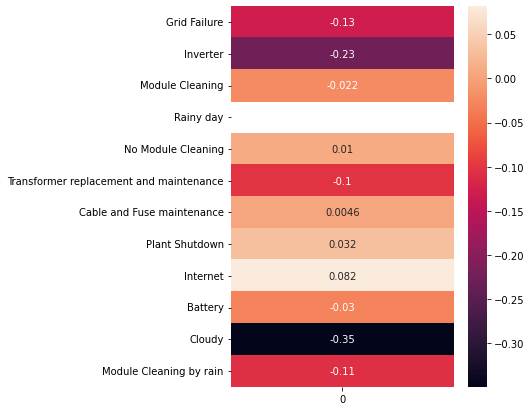

In [145]:
df_corr = pd.DataFrame(correlation,index=labels)
plt.figure(figsize=(5,7))
sn.heatmap(df_corr, annot=True)
plt.show()

###Issue

In [146]:
for k in labels:
  df3 = df2.where(df2[k] !=0 ).dropna()
  df3 = df3.append(total)

  df3['Total Generation (KWH)']=df3['Total Generation (KWH)'].astype(float)
  df3['Grid Failure']=df3['Grid Failure'].astype(float)
  df3['Inverter']=df3['Inverter'].astype(float)
  df3['Module Cleaning']=df3['Module Cleaning'].astype(bool)
  df3['Rainy day']=df3['Rainy day'].astype(bool)
  df3['No Module Cleaning']=df3['No Module Cleaning'].astype(bool)
  df3['Transformer replacement and maintenance']=df3['Transformer replacement and maintenance'].astype(bool)
  df3['Cable and Fuse maintenance']=df3['Cable and Fuse maintenance'].astype(bool)
  df3['Plant Shutdown']=df3['Plant Shutdown'].astype(float)
  df3['Internet']=df3['Internet'].astype(float)
  df3['Battery']=df3['Battery'].astype(bool)
  df3['Cloudy']=df3['Cloudy'].astype(bool)
  df3['Module Cleaning by rain']=df3['Module Cleaning by rain'].astype(bool)

  corr_2.append(df3.corr().loc['Total Generation (KWH)',k])
  del df3

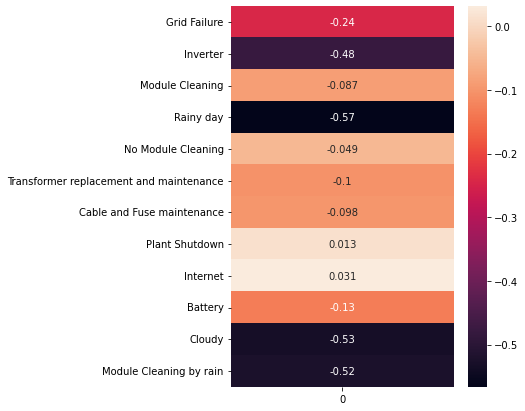

In [147]:
df_corr_2 = pd.DataFrame(corr_2,index=labels)
plt.figure(figsize=(5,7))
sn.heatmap(df_corr_2, annot=True)
plt.show()

In [37]:
del total, grid_failure, inverter, module_cleaning, rainy_day, no_module_cleaning, transformer_maintenance, cable_fuse, plant_shutdown, internet, battery, cloudy, module_cleaning_rain

#VAR

In [162]:
df3 = df2[0:2369]
df3

Total Generation (KWH)  Grid Failure  Inverter  Module Cleaning  \
Date                                                                          
2012-07-06                 3218.00           5.0       0.0            False   
2012-07-07                 3633.00           5.0       0.0            False   
2012-07-08                 4377.00           0.0       0.0            False   
2012-07-09                 4625.00           0.0       0.0            False   
2012-07-10                  648.00           0.0       0.0            False   
...                            ...           ...       ...              ...   
2018-12-27                 4129.29          12.0       0.0             True   
2018-12-28                 4266.50           0.0       0.0             True   
2018-12-29                 3732.03          56.0       0.0             True   
2018-12-30                 4063.88           0.0       0.0            False   
2018-12-31                 4093.90           5.0       0.0             True   

            Rainy day  No Module Cleaning  \
Date                                        
2012-07-06      False               False   
2012-07-07      False               False   
2012-07-08      False               False   
2012-07-09      False               False   
2012-07-10      False               False   
...               ...                 ...   
2018-12-27      False               False   
2018-12-28      False               False   
2018-12-29      False               False   
2018-12-30      False               False   
2018-12-31      False               False   

            Transformer replacement and maintenance  \
Date                                                  
2012-07-06                                    False   
2012-07-07                                    False   
2012-07-08                                    False   
2012-07-09                                    False   
2012-07-10                                    False   
...                                             ...   
2018-12-27                                    False   
2018-12-28                                    False   
2018-12-29                                    False   
2018-12-30                                    False   
2018-12-31                                    False   

            Cable and Fuse maintenance  Plant Shutdown  Internet  Battery  \
Date                                                                        
2012-07-06                       False             0.0       0.0    False   
2012-07-07                       False             0.0       0.0    False   
2012-07-08                       False             0.0       0.0    False   
2012-07-09                       False             0.0       0.0    False   
2012-07-10                       False             0.0       0.0    False   
...                                ...             ...       ...      ...   
2018-12-27                       False             0.0       0.0    False   
2018-12-28                       False             0.0       0.0    False   
2018-12-29                       False             0.0       0.0    False   
2018-12-30                       False             0.0       0.0    False   
2018-12-31                       False             0.0       0.0    False   

            Cloudy  Module Cleaning by rain  
Date                                         
2012-07-06   False                    False  
2012-07-07   False                    False  
2012-07-08   False                    False  
2012-07-09   False                    False  
2012-07-10   False                    False  
...            ...                      ...  
2018-12-27   False                    False  
2018-12-28   False                    False  
2018-12-29   False                    False  
2018-12-30   False                    False  
2018-12-31   False                    False  

[2369 rows x 13 columns]

In [163]:
df3.corr()

Total Generation (KWH)  Grid Failure  \
Total Generation (KWH)                                 1.000000     -0.172953   
Grid Failure                                          -0.172953      1.000000   
Inverter                                              -0.043736     -0.007160   
Module Cleaning                                        0.127412     -0.034275   
Rainy day                                             -0.377486      0.024930   
No Module Cleaning                                    -0.005518     -0.027104   
Transformer replacement and maintenance               -0.035031     -0.011423   
Cable and Fuse maintenance                             0.032253     -0.001849   
Plant Shutdown                                         0.000595     -0.007984   
Internet                                               0.056614     -0.015192   
Battery                                               -0.042772     -0.020379   
Cloudy                                                -0.432016      0.021323   
Module Cleaning by rain                               -0.274546      0.050050   

                                         Inverter  Module Cleaning  Rainy day  \
Total Generation (KWH)                  -0.043736         0.127412  -0.377486   
Grid Failure                            -0.007160        -0.034275   0.024930   
Inverter                                 1.000000        -0.057396  -0.018526   
Module Cleaning                         -0.057396         1.000000  -0.198309   
Rainy day                               -0.018526        -0.198309   1.000000   
No Module Cleaning                      -0.015645        -0.138197  -0.054984   
Transformer replacement and maintenance -0.007053         0.050869  -0.006252   
Cable and Fuse maintenance              -0.013646         0.036891   0.000945   
Plant Shutdown                          -0.003330        -0.029419  -0.011705   
Internet                                -0.009592        -0.084728  -0.033710   
Battery                                 -0.008655        -0.076452  -0.030418   
Cloudy                                  -0.032986        -0.207054   0.627592   
Module Cleaning by rain                 -0.016774        -0.126362   0.267430   

                                         No Module Cleaning  \
Total Generation (KWH)                            -0.005518   
Grid Failure                                      -0.027104   
Inverter                                          -0.015645   
Module Cleaning                                   -0.138197   
Rainy day                                         -0.054984   
No Module Cleaning                                 1.000000   
Transformer replacement and maintenance           -0.016983   
Cable and Fuse maintenance                         0.008284   
Plant Shutdown                                    -0.008019   
Internet                                          -0.023095   
Battery                                           -0.020839   
Cloudy                                             0.032757   
Module Cleaning by rain                           -0.045420   

                                         Transformer replacement and maintenance  \
Total Generation (KWH)                                                 -0.035031   
Grid Failure                                                           -0.011423   
Inverter                                                               -0.007053   
Module Cleaning                                                         0.050869   
Rainy day                                                              -0.006252   
No Module Cleaning                                                     -0.016983   
Transformer replacement and maintenance                                 1.000000   
Cable and Fuse maintenance                                             -0.014813   
Plant Shutdown                                                         -0.003615   
Internet                                        

In [164]:
df3 = df3.drop(["Cable and Fuse maintenance","No Module Cleaning","Rainy day","Transformer replacement and maintenance","Plant Shutdown","Internet","Battery","Module Cleaning by rain"], axis=1)
df3

Total Generation (KWH)  Grid Failure  Inverter  Module Cleaning  \
Date                                                                          
2012-07-06                 3218.00           5.0       0.0            False   
2012-07-07                 3633.00           5.0       0.0            False   
2012-07-08                 4377.00           0.0       0.0            False   
2012-07-09                 4625.00           0.0       0.0            False   
2012-07-10                  648.00           0.0       0.0            False   
...                            ...           ...       ...              ...   
2018-12-27                 4129.29          12.0       0.0             True   
2018-12-28                 4266.50           0.0       0.0             True   
2018-12-29                 3732.03          56.0       0.0             True   
2018-12-30                 4063.88           0.0       0.0            False   
2018-12-31                 4093.90           5.0       0.0             True   

            Cloudy  
Date                
2012-07-06   False  
2012-07-07   False  
2012-07-08   False  
2012-07-09   False  
2012-07-10   False  
...            ...  
2018-12-27   False  
2018-12-28   False  
2018-12-29   False  
2018-12-30   False  
2018-12-31   False  

[2369 rows x 5 columns]

In [165]:
endog_array = df3.to_numpy(dtype=float)

In [166]:
var_model = VAR(endog_array)

In [167]:
var_model.select_order(48).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [168]:
results = var_model.fit(15, trend='c', ic='aic')

In [169]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 24, Sep, 2022
Time:                     04:56:13
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    22.9636
Nobs:                     2354.00    HQIC:                   22.3719
Log likelihood:          -42253.9    FPE:                3.70604e+09
AIC:                      22.0331    Det(Omega_mle):     3.16163e+09
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const        391.490905        89.985821            4.351           0.000
L1.y1          0.568456         0.021956           25.891           0.000
L1.y2          1.041002         0.309884            3.359           0.001
L1.y3         -0.

In [170]:
forecast_days = 12

In [171]:
forecast_results = results.forecast(df3.values,steps=forecast_days)

In [172]:
forecast_power = []
grid_pred = []
inverter_pred = []
module_pred = []
cloudy_pred = []
for i in forecast_results:
    forecast_power.append(i[0])
    grid_pred.append(i[1])
    inverter_pred.append(i[2])
    module_pred.append(i[3])
    cloudy_pred.append(i[4])

In [173]:
df_obj=df2[2369:2734] #whole 2019 year

In [174]:
power_16 = df_obj['Total Generation (KWH)']
diff_power = pd.DataFrame({"Prediction":forecast_power[:forecast_days],"Original":power_16[:forecast_days],
                           "Grid_pred":grid_pred[:forecast_days],
                          "Module_pred":module_pred[:forecast_days],"Cloudy_pred":cloudy_pred[:forecast_days],
                          "Inverter_pred":inverter_pred[:forecast_days]})
diff_power['Difference'] = diff_power['Prediction'] - diff_power['Original']
diff_power

Prediction  Original  Grid_pred  Module_pred  Cloudy_pred  \
Date                                                                     
2019-01-01  3929.014529   3812.94   5.707460     0.903061     0.027050   
2019-01-02  3919.972509   3920.74  10.358995     0.884056     0.001324   
2019-01-03  4004.213219   4113.45   3.544689     0.860784     0.015408   
2019-01-04  3993.981208   3873.59  14.741385     0.849607     0.024959   
2019-01-05  3896.393233   3603.61  23.432841     0.893723     0.018115   
2019-01-06  3886.120607   4401.37  10.003201     0.225994     0.033636   
2019-01-07  3867.694410   3852.56  10.534484     0.927091     0.060681   
2019-01-08  3839.339022   3913.55  11.890221     0.810281     0.060335   
2019-01-09  3943.546077   3731.08  11.040974     0.806541     0.052878   
2019-01-10  3987.798912   4058.75   9.840505     0.784852     0.049967   
2019-01-11  3946.842438   4077.43   9.684476     0.769380     0.053148   
2019-01-12  3905.154685   3923.99  24.017230     0.834102     0.057249   

            Inverter_pred  Difference  
Date                                   
2019-01-01       4.047716  116.074529  
2019-01-02       2.628204   -0.767491  
2019-01-03       4.749287 -109.236781  
2019-01-04       5.477693  120.391208  
2019-01-05       5.602743  292.783233  
2019-01-06       4.257347 -515.249393  
2019-01-07       1.630265   15.134410  
2019-01-08       3.401343  -74.210978  
2019-01-09       0.444994  212.466077  
2019-01-10       0.929394  -70.951088  
2019-01-11       1.336929 -130.587562  
2019-01-12       2.264341  -18.835315

In [175]:
rmse = mean_squared_error(power_16[:forecast_days],forecast_power)**(1/2)
rmse

196.72837717196327

In [176]:
mae = mean_absolute_error(power_16[:forecast_days],forecast_power)
mae

139.72400558283152

In [177]:
rmspe = round(np.sqrt(np.mean(np.square(((power_16[:forecast_days] - forecast_power) / power_16[:forecast_days])), axis=0))*100,3)
rmspe

4.82

Text(0.5, 1.0, '12_Days Prediction')

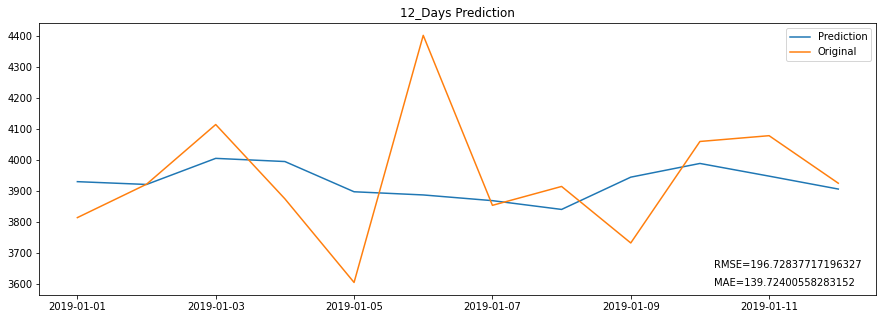

In [185]:
fig = plt.figure(figsize=(15,5))
plt.plot('Prediction', data=diff_power, label='Prediction')
plt.plot('Original', data=diff_power, label='Original')
plt.legend()
plt.figtext(.75, .2, "RMSE="+str(rmse))
plt.figtext(.75, .15, "MAE="+str(mae))
plt.title('12_Days Prediction')

#VAR (with Insolation)

In [187]:
df_insol = df1[['Total Generation (KWH)','Insolation']]

In [188]:
df_insol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3320 entries, 0 to 3319
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Total Generation (KWH)  3320 non-null   object
 1   Insolation              2549 non-null   object
dtypes: object(2)
memory usage: 52.0+ KB


In [189]:
df_insol.sort_values(by = "Insolation",ascending=False).head(15)

Total Generation (KWH) Insolation
426                 4101.88       4240
1083                 787.44        998
796                  631.82        816
748                  482.41        685
3031                4270.99       9.63
3079                 864.28       8.22
239                 5934.85      7.727
240                 5971.72      7.568
237                  6097.2      7.541
238                 5959.91      7.519
985                 5884.42      7.515
1355                5100.48       7.48
986                 5652.55       7.45
620                 6083.13      7.435
1711                5414.22       7.43

In [190]:
avg = df_insol.drop([426,1083,796,748]).mean()

In [191]:
df4 = pd.DataFrame()

df4['Total Generation (KWH)'] = final_df_2['Total Generation (KWH)'].astype(float)
df4['Grid Failure'] = final_df_2['Grid Failure'].astype(float)
df4['Inverter'] = final_df_2['Inverter'].astype(float)
df4['Module Cleaning'] = final_df_2['Module Cleaning'].astype(bool)
df4['Rainy day'] = final_df_2['Rainy day'].astype(bool)
df4['No Module Cleaning'] = final_df_2['No Module Cleaning'].astype(bool)
df4['Transformer replacement and maintenance'] = final_df_2['Transformer replacement and maintenance'].astype(bool)
df4['Cable and Fuse maintenance'] = final_df_2['Cable and Fuse maintenance'].astype(bool)
df4['Plant Shutdown'] = final_df_2['Plant Shutdown'].astype(float)
df4['Internet'] = final_df_2['Internet'].astype(float)
df4['Battery'] = final_df_2['Battery'].astype(bool)
df4['Cloudy'] = final_df_2['Cloudy'].astype(bool)
df4['Module Cleaning by rain'] = final_df_2['Module Cleaning by rain'].astype(bool)
df4['Insolation'] = final_df_2['Insolation']
df4['Insolation'] = df4['Insolation'].fillna(avg[1])

df4.index = final_df_2['Date']
df4

Total Generation (KWH)  Grid Failure  Inverter  Module Cleaning  \
Date                                                                          
2012-07-06                 3218.00           5.0       0.0            False   
2012-07-07                 3633.00           5.0       0.0            False   
2012-07-08                 4377.00           0.0       0.0            False   
2012-07-09                 4625.00           0.0       0.0            False   
2012-07-10                  648.00           0.0       0.0            False   
...                            ...           ...       ...              ...   
2021-08-04                 2052.94           5.0       0.0            False   
2021-08-05                 2605.47           0.0       0.0             True   
2021-08-06                 2515.78           0.0       0.0             True   
2021-08-07                 2578.53           0.0       0.0             True   
2021-08-08                 2923.18           0.0       0.0            False   

            Rainy day  No Module Cleaning  \
Date                                        
2012-07-06      False               False   
2012-07-07      False               False   
2012-07-08      False               False   
2012-07-09      False               False   
2012-07-10      False               False   
...               ...                 ...   
2021-08-04      False               False   
2021-08-05      False               False   
2021-08-06      False               False   
2021-08-07      False               False   
2021-08-08      False               False   

            Transformer replacement and maintenance  \
Date                                                  
2012-07-06                                    False   
2012-07-07                                    False   
2012-07-08                                    False   
2012-07-09                                    False   
2012-07-10                                    False   
...                                             ...   
2021-08-04                                    False   
2021-08-05                                    False   
2021-08-06                                    False   
2021-08-07                                    False   
2021-08-08                                    False   

            Cable and Fuse maintenance  Plant Shutdown  Internet  Battery  \
Date                                                                        
2012-07-06                       False             0.0       0.0    False   
2012-07-07                       False             0.0       0.0    False   
2012-07-08                       False             0.0       0.0    False   
2012-07-09                       False             0.0       0.0    False   
2012-07-10                       False             0.0       0.0    False   
...                                ...             ...       ...      ...   
2021-08-04                       False             0.0       0.0    False   
2021-08-05                       False             0.0       0.0    False   
2021-08-06                       False             0.0       0.0    False   
2021-08-07                       False             0.0       0.0    False   
2021-08-08                       False             0.0       0.0    False   

            Cloudy  Module Cleaning by rain  Insolation  
Date                                                     
2012-07-06   False                    False    5.246102  
2012-07-07   False                    False    5.246102  
2012-07-08   False                    False    5.246102  
2012-07-09   False                    False    5.246102  
2012-07-10   False                    False    5.246102  
...            ...                      ...         ...  
2021-08-04   False                    False    2.485000  
2021-08-05   False                    False    3.225000  
2021-08-06   False                    False    3.065000  
2021-08-07   False                    Fals

In [192]:
df3 = df4[0:2369]
df3

Total Generation (KWH)  Grid Failure  Inverter  Module Cleaning  \
Date                                                                          
2012-07-06                 3218.00           5.0       0.0            False   
2012-07-07                 3633.00           5.0       0.0            False   
2012-07-08                 4377.00           0.0       0.0            False   
2012-07-09                 4625.00           0.0       0.0            False   
2012-07-10                  648.00           0.0       0.0            False   
...                            ...           ...       ...              ...   
2018-12-27                 4129.29          12.0       0.0             True   
2018-12-28                 4266.50           0.0       0.0             True   
2018-12-29                 3732.03          56.0       0.0             True   
2018-12-30                 4063.88           0.0       0.0            False   
2018-12-31                 4093.90           5.0       0.0             True   

            Rainy day  No Module Cleaning  \
Date                                        
2012-07-06      False               False   
2012-07-07      False               False   
2012-07-08      False               False   
2012-07-09      False               False   
2012-07-10      False               False   
...               ...                 ...   
2018-12-27      False               False   
2018-12-28      False               False   
2018-12-29      False               False   
2018-12-30      False               False   
2018-12-31      False               False   

            Transformer replacement and maintenance  \
Date                                                  
2012-07-06                                    False   
2012-07-07                                    False   
2012-07-08                                    False   
2012-07-09                                    False   
2012-07-10                                    False   
...                                             ...   
2018-12-27                                    False   
2018-12-28                                    False   
2018-12-29                                    False   
2018-12-30                                    False   
2018-12-31                                    False   

            Cable and Fuse maintenance  Plant Shutdown  Internet  Battery  \
Date                                                                        
2012-07-06                       False             0.0       0.0    False   
2012-07-07                       False             0.0       0.0    False   
2012-07-08                       False             0.0       0.0    False   
2012-07-09                       False             0.0       0.0    False   
2012-07-10                       False             0.0       0.0    False   
...                                ...             ...       ...      ...   
2018-12-27                       False             0.0       0.0    False   
2018-12-28                       False             0.0       0.0    False   
2018-12-29                       False             0.0       0.0    False   
2018-12-30                       False             0.0       0.0    False   
2018-12-31                       False             0.0       0.0    False   

            Cloudy  Module Cleaning by rain  Insolation  
Date                                                     
2012-07-06   False                    False    5.246102  
2012-07-07   False                    False    5.246102  
2012-07-08   False                    False    5.246102  
2012-07-09   False                    False    5.246102  
2012-07-10   False                    False    5.246102  
...            ...                      ...         ...  
2018-12-27   False                    False    5.747000  
2018-12-28   False                    False    5.689000  
2018-12-29   False                    False    5.834000  
2018-12-30   False                    Fals

In [193]:
df3 = df3.drop(["Cable and Fuse maintenance","No Module Cleaning","Rainy day","Transformer replacement and maintenance","Plant Shutdown","Internet","Battery","Module Cleaning by rain"], axis=1)
df3

Total Generation (KWH)  Grid Failure  Inverter  Module Cleaning  \
Date                                                                          
2012-07-06                 3218.00           5.0       0.0            False   
2012-07-07                 3633.00           5.0       0.0            False   
2012-07-08                 4377.00           0.0       0.0            False   
2012-07-09                 4625.00           0.0       0.0            False   
2012-07-10                  648.00           0.0       0.0            False   
...                            ...           ...       ...              ...   
2018-12-27                 4129.29          12.0       0.0             True   
2018-12-28                 4266.50           0.0       0.0             True   
2018-12-29                 3732.03          56.0       0.0             True   
2018-12-30                 4063.88           0.0       0.0            False   
2018-12-31                 4093.90           5.0       0.0             True   

            Cloudy  Insolation  
Date                            
2012-07-06   False    5.246102  
2012-07-07   False    5.246102  
2012-07-08   False    5.246102  
2012-07-09   False    5.246102  
2012-07-10   False    5.246102  
...            ...         ...  
2018-12-27   False    5.747000  
2018-12-28   False    5.689000  
2018-12-29   False    5.834000  
2018-12-30   False    5.584000  
2018-12-31   False    5.635000  

[2369 rows x 6 columns]

In [194]:
endog_array = df3.to_numpy(dtype=float)

In [195]:
var_model2 = VAR(endog_array)

In [196]:
var_model2.select_order(48).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [197]:
results = var_model2.fit(15, trend='c', ic='aic')

In [198]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 24, Sep, 2022
Time:                     04:59:53
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    32.4435
Nobs:                     2354.00    HQIC:                   31.5935
Log likelihood:          -56107.6    FPE:                3.23250e+13
AIC:                      31.1066    Det(Omega_mle):     2.57456e+13
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const        380.218913        90.180690            4.216           0.000
L1.y1          0.566885         0.022040           25.721           0.000
L1.y2          1.043918         0.310233            3.365           0.001
L1.y3         -0.

In [237]:
forecast_days = 3

In [238]:
forecast_results = results.forecast(df3.values,steps=forecast_days)

In [239]:
forecast_power = []
grid_pred = []
inverter_pred = []
module_pred = []
cloudy_pred = []
for i in forecast_results:
    forecast_power.append(i[0])
    grid_pred.append(i[1])
    inverter_pred.append(i[2])
    module_pred.append(i[3])
    cloudy_pred.append(i[4])

In [240]:
df_obj=df4[2369:2734] #whole 2019 year

In [241]:
power_16 = df_obj['Total Generation (KWH)']
diff_power = pd.DataFrame({"Prediction":forecast_power[:forecast_days],"Original":power_16[:forecast_days],
                           "Grid_pred":grid_pred[:forecast_days],
                          "Module_pred":module_pred[:forecast_days],"Cloudy_pred":cloudy_pred[:forecast_days],
                          "Inverter_pred":inverter_pred[:forecast_days]})
diff_power['Difference'] = diff_power['Prediction'] - diff_power['Original']
diff_power

Prediction  Original  Grid_pred  Module_pred  Cloudy_pred  \
Date                                                                     
2019-01-01  3926.598801   3812.94   5.736792     0.902798     0.027187   
2019-01-02  3919.328054   3920.74  10.287917     0.884268     0.001882   
2019-01-03  4003.633025   4113.45   3.562636     0.860629     0.015301   

            Inverter_pred  Difference  
Date                                   
2019-01-01       4.099757  113.658801  
2019-01-02       2.619468   -1.411946  
2019-01-03       4.680791 -109.816975

In [242]:
rmse = mean_squared_error(power_16[:forecast_days],forecast_power)**(1/2)
rmse

91.250725579014

In [243]:
mae = mean_absolute_error(power_16[:forecast_days],forecast_power)
mae

74.96257413909582

In [244]:
rmspe = round(np.sqrt(np.mean(np.square(((power_16[:forecast_days] - forecast_power) / power_16[:forecast_days])), axis=0))*100,3)
rmspe

2.31

Text(0.5, 1.0, '3_Days Prediction')

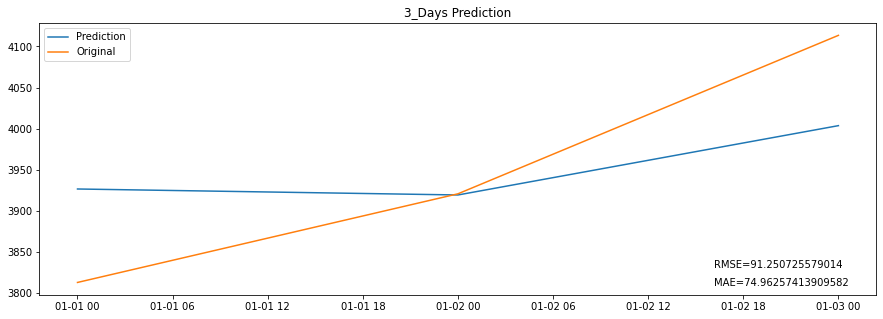

In [245]:
fig = plt.figure(figsize=(15,5))
plt.plot('Prediction', data=diff_power, label='Prediction')
plt.plot('Original', data=diff_power, label='Original')
plt.legend()
plt.figtext(.75, .2, "RMSE="+str(rmse))
plt.figtext(.75, .15, "MAE="+str(mae))
plt.title('3_Days Prediction')

#From here nothing was used 

#VAR_2 (SARIMAX + VAR)

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX

df3 = df3.drop(["Total Generation (KWH)"],axis=1)
df3

Grid Failure  Inverter  Module Cleaning  Cloudy
Date                                                       
2012-07-06           5.0       0.0            False   False
2012-07-07           5.0       0.0            False   False
2012-07-08           0.0       0.0            False   False
2012-07-09           0.0       0.0            False   False
2012-07-10           0.0       0.0            False   False
...                  ...       ...              ...     ...
2018-12-27          12.0       0.0             True   False
2018-12-28           0.0       0.0             True   False
2018-12-29          56.0       0.0             True   False
2018-12-30           0.0       0.0            False   False
2018-12-31           5.0       0.0             True   False

[2369 rows x 4 columns]

In [ ]:
exog = df3.to_numpy(dtype=int)

In [ ]:
model = VAR(exog)

In [ ]:
model.select_order(48).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
output = model.fit(15)

In [ ]:
output.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Mar, 2022
Time:                     13:00:41
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    9.62544
Nobs:                     2354.00    HQIC:                   9.24556
Log likelihood:          -23742.7    FPE:                    8333.52
AIC:                      9.02799    Det(Omega_mle):         7522.91
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          7.162554         1.761079            4.067           0.000
L1.y1          0.019874         0.020908            0.951           0.342
L1.y2         -0.009617         0.028303           -0.340           0.734
L1.y3         -7.

In [ ]:
forecast_days = 10

In [ ]:
lag2 = output.k_ar

In [ ]:
forecast_output = output.forecast(df3.values[-lag2:],steps=forecast_days)

In [ ]:
grid_pred = []
inverter_pred = []
module_pred = []
cloudy_pred = []
for i in forecast_output:
    grid_pred.append(i[0])
    inverter_pred.append(i[1])
    module_pred.append(i[2])
    cloudy_pred.append(i[3])

In [ ]:
op = pd.DataFrame()
op['grid_pred'] = grid_pred
op['inverter_pred'] = inverter_pred
op['module_pred'] = module_pred
op['cloudy_pred'] = cloudy_pred

op

grid_pred  inverter_pred  module_pred  cloudy_pred
0   9.176889       3.160054     0.884910     0.023931
1   9.739626       2.103299     0.848740     0.008982
2   5.765081       0.408426     0.854354     0.015258
3   7.893105      -0.085537     0.840009     0.024653
4  26.056495       0.062778     0.879581     0.017819
5   9.969272       0.973611     0.223184     0.024493
6  10.613991       0.312670     0.921611     0.041988
7  14.951061       4.692695     0.805514     0.044862
8   9.800518       1.489234     0.795767     0.039944
9  10.821063       1.404588     0.780015     0.040550

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

df4 = df2['Total Generation (KWH)']
df4 = df4[0:2369]
df4

Date
2012-07-06    3218.00
2012-07-07    3633.00
2012-07-08    4377.00
2012-07-09    4625.00
2012-07-10     648.00
               ...   
2018-12-27    4129.29
2018-12-28    4266.50
2018-12-29    3732.03
2018-12-30    4063.88
2018-12-31    4093.90
Name: Total Generation (KWH), Length: 2369, dtype: float64

In [ ]:
  model2 = SARIMAX(df4, exog=exog, order=(15,0,0), seasonal_order=(0,0,0,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
model2_fit = model2.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
pred = model2_fit.forecast(steps=10,exog=op)
pred

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2369    4170.839861
2370    3915.260768
2371    4005.762130
2372    4026.034592
2373    3653.229312
2374    3343.841067
2375    3515.753719
2376    3799.978203
2377    3711.866390
2378    3769.650776
dtype: float64

In [ ]:
df_obj2 = df2['Total Generation (KWH)']
df_obj2 = df_obj2[2369:2734]
df_obj2=df_obj2[:forecast_days]

In [ ]:
rmse = mean_squared_error(df_obj2,pred)**(1/2)
rmse

386.53233138893546

In [ ]:
mae = mean_absolute_error(df_obj2,pred)
mae

248.93507112913

#TSA

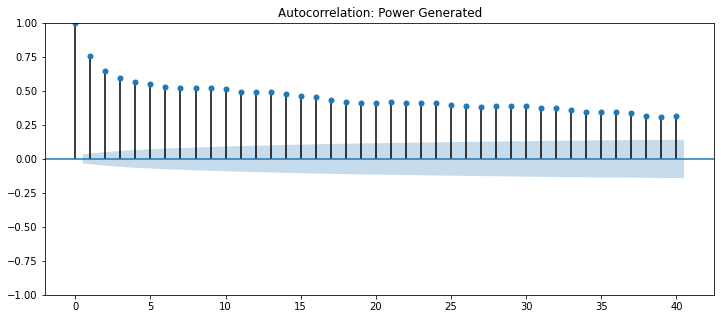

In [ ]:
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig, ax = plt.subplots(figsize=(12,5))

acf(df2['Total Generation (KWH)'])
title = 'Autocorrelation: Power Generated'
lags = 40
plot_acf(df2['Total Generation (KWH)'],title=title,lags=lags,ax=ax);

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


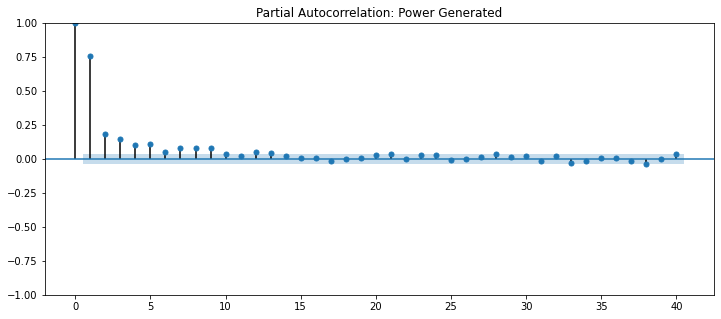

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
title='Partial Autocorrelation: Power Generated'
lags=40
plot_pacf(df2['Total Generation (KWH)'],title=title,lags=lags,ax=ax);

In [ ]:
from statsmodels.tsa.stattools import adfuller

#creating a report
dftest = adfuller(df2['Total Generation (KWH)'])
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():           #for critical value 1%, 5%, 10%
    dfout[f'critical value ({key})']=val
print(dfout)


ADF test statistic     -6.011310e+00
p-value                 1.571057e-07
# lags used             1.200000e+01
# observations          3.304000e+03
critical value (1%)    -3.432331e+00
critical value (5%)    -2.862415e+00
critical value (10%)   -2.567236e+00
dtype: float64


In [ ]:
#!pip install pmdarima

In [ ]:
from pmdarima import auto_arima

auto_arima(df2['Total Generation (KWH)'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3317
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -26311.347
Date:                Mon, 17 Jan 2022   AIC                          52628.693
Time:                        10:33:42   BIC                          52647.013
Sample:                             0   HQIC                         52635.249
                               - 3317                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4403      0.015     29.204      0.000       0.411       0.470
ma.L1         -0.8954      0.009    -96.890      0.000      -0.914      -0.877
sigma2      4.563e+05   6424.448     71.031      0.000    4.44e+05    4.69e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              2954.63
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###Models

In [ ]:
train_data = df2.iloc[:2900,0]
test_data = df2.iloc[2900:,0]

In [ ]:
from statsmodels.tsa.ar_model import AutoReg, ARResults

model = AutoReg(train_data,lags=1)
ARfit = model.fit()
ARfit.params

const                        953.403390
Total Generation (KWH).L1      0.757759
dtype: float64

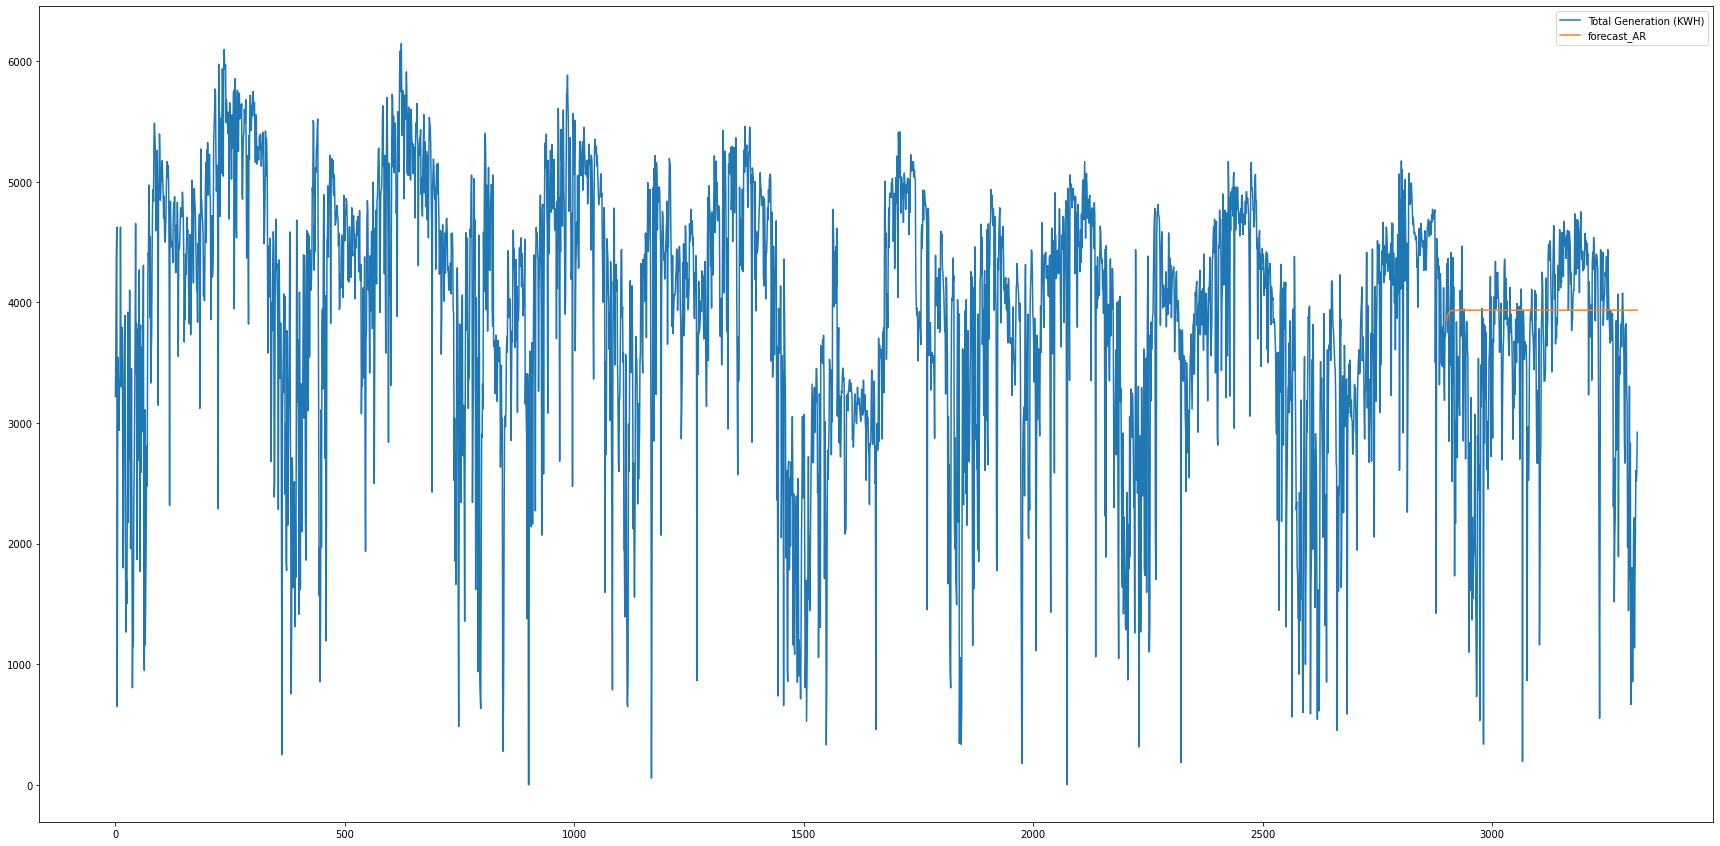

In [ ]:
df2['forecast_AR'] = ARfit.predict(start=2900,end=3317)
df2[['Total Generation (KWH)','forecast_AR']].plot(figsize=(30,15))

In [ ]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
import statsmodels.api as sm

model = sm.tsa.ARIMA(train_data,order=(1,0,1))
ARMAfit = model.fit()
ARMAfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     Total Generation (KWH)   No. Observations:                 2900
Model:                     ARIMA(1, 0, 1)   Log Likelihood              -23110.601
Date:                    Mon, 17 Jan 2022   AIC                          46229.203
Time:                            10:33:54   BIC                          46253.092
Sample:                                 0   HQIC                         46237.811
                                   - 2900                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3934.8637    112.273     35.047      0.000    3714.812    4154.915
ar.L1          0.9057      0.010     91.007      0.000       0.886       0.925
ma.L1         -0.3918      0.016    -24.838      0.000      -0.423      -0.361
sigma2      4.943e+05   9162.461     53.946      0.000    4.76e+05    5.12e+05
===================================================================================
Ljung-Box (L1) (Q):                   9.83   Jarque-Bera (JB):              2347.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -1.02
Prob(H) (two-sided):                  0.09   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

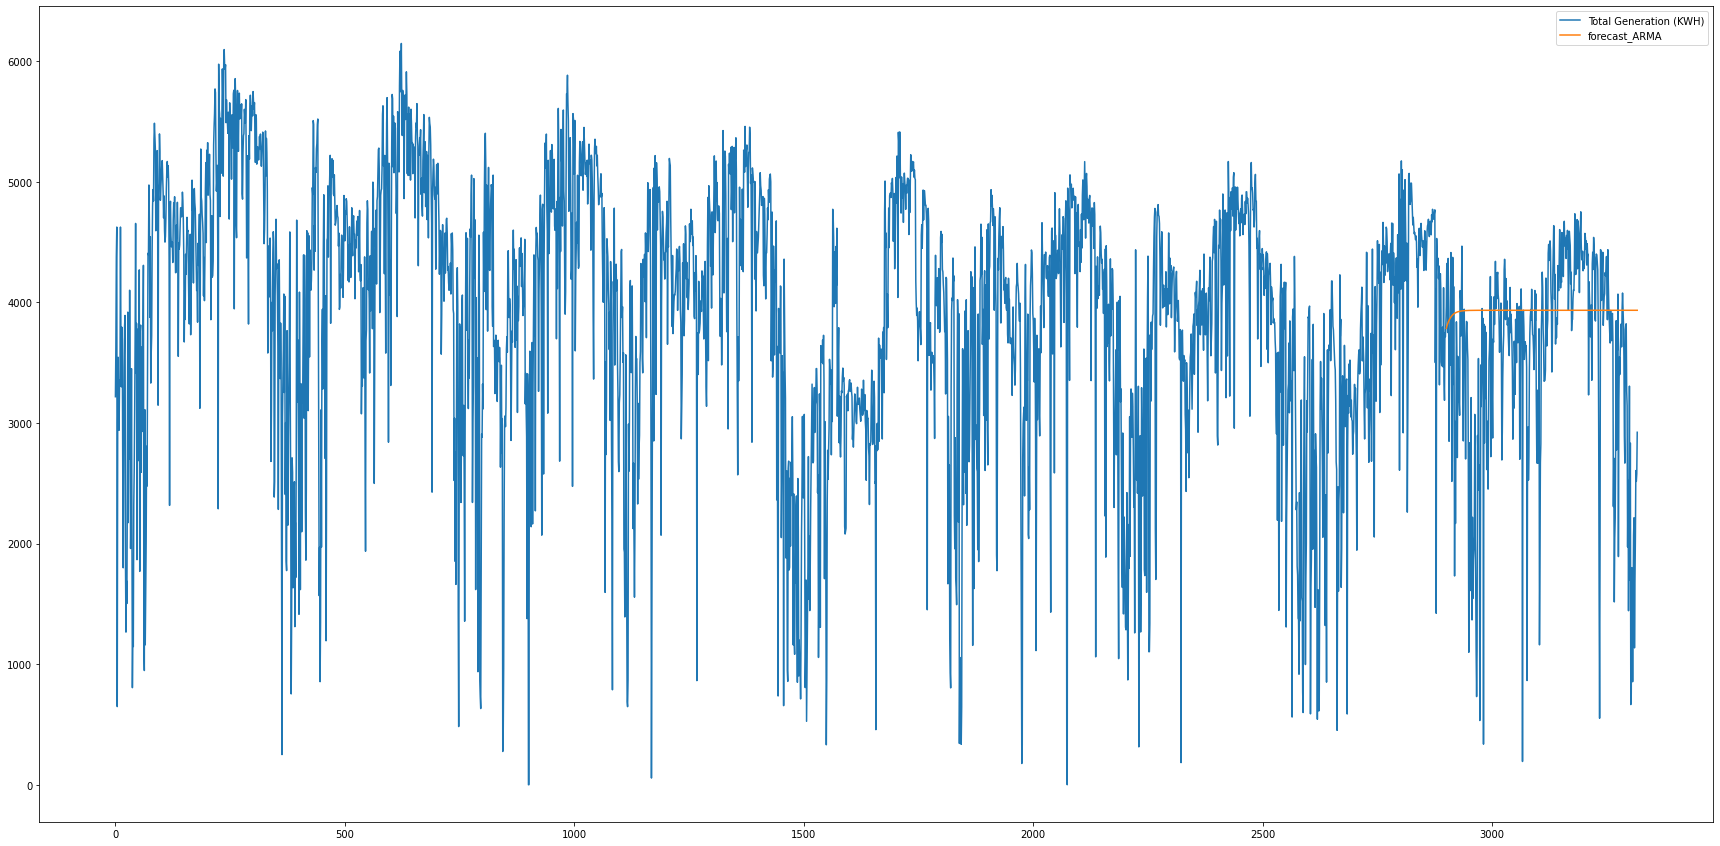

In [ ]:
df2['forecast_ARMA'] = ARMAfit.predict(start=2900,end=3317)
df2[['Total Generation (KWH)','forecast_ARMA']].plot(figsize=(30,15))

In [ ]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
import statsmodels.api as sm

model = sm.tsa.ARIMA(train_data,order=(1,1,1))
ARIMAfit = model.fit()
ARIMAfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     Total Generation (KWH)   No. Observations:                 2900
Model:                     ARIMA(1, 1, 1)   Log Likelihood              -23035.118
Date:                    Mon, 17 Jan 2022   AIC                          46076.237
Time:                            10:34:00   BIC                          46094.153
Sample:                                 0   HQIC                         46082.693
                                   - 2900                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4442      0.016     27.528      0.000       0.413       0.476
ma.L1         -0.8975      0.010    -91.272      0.000      -0.917      -0.878
sigma2      4.667e+05   7151.095     65.259      0.000    4.53e+05    4.81e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2350.38
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -1.01
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

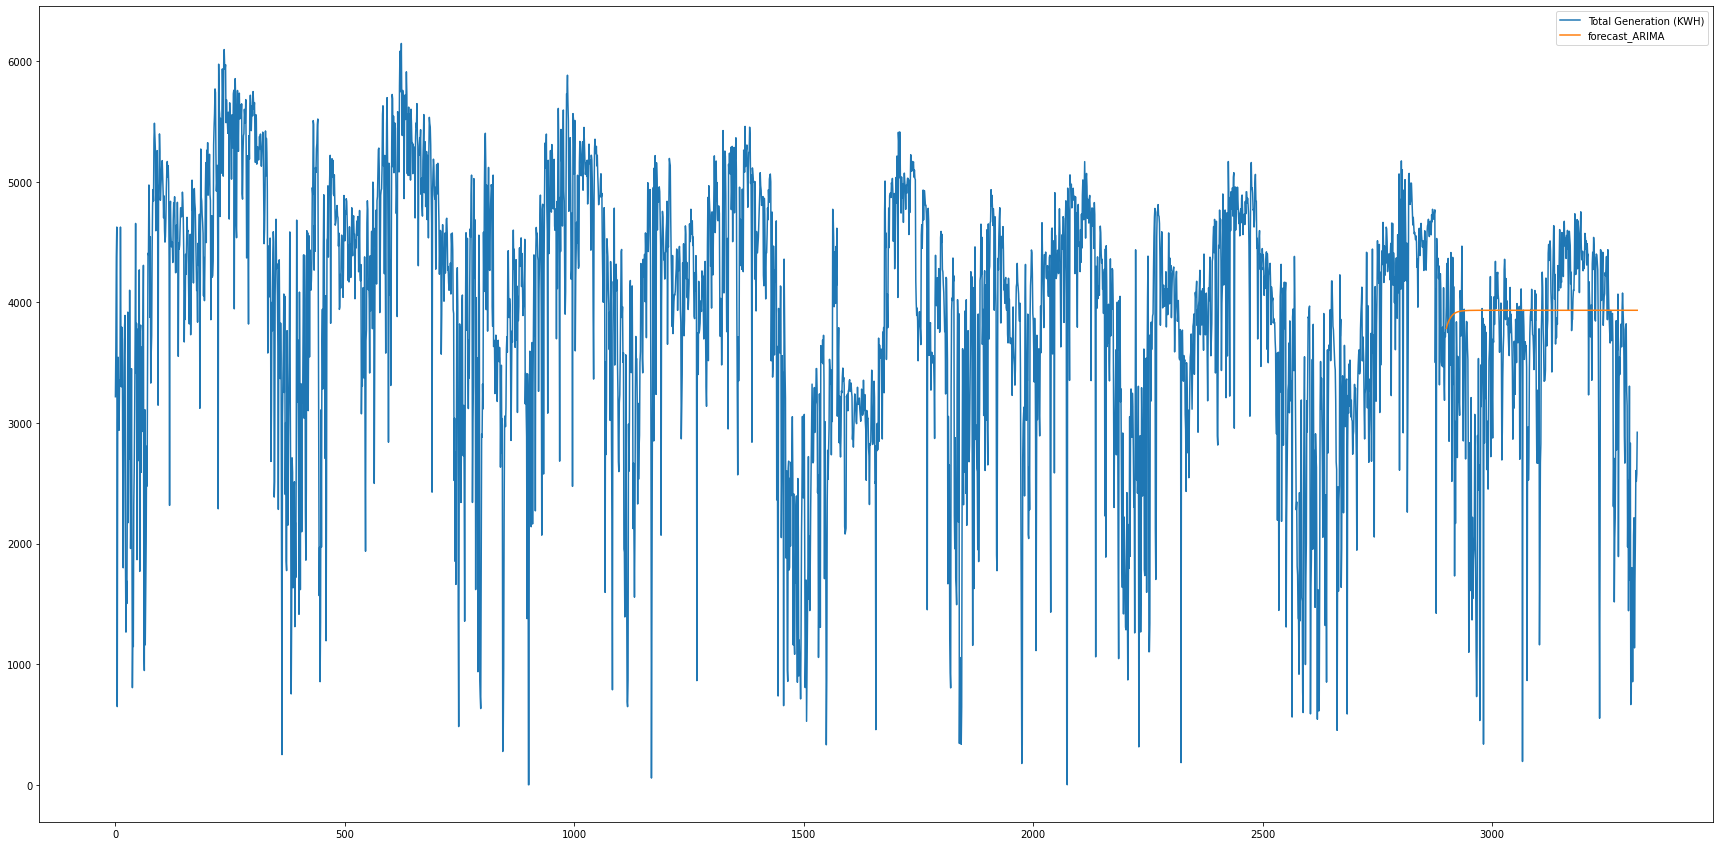

In [ ]:
df2['forecast_ARIMA'] = ARMAfit.predict(start=2900,end=3317)
df2[['Total Generation (KWH)','forecast_ARIMA']].plot(figsize=(30,15))

In [ ]:
df2 = df2[2900:]
df2

Total Generation (KWH)  Grid Failure  ...  forecast_ARMA  forecast_ARIMA
2900                 3968.07           0.0  ...    3785.377817     3785.377817
2901                 4310.16           0.0  ...    3799.471190     3799.471190
2902                 4324.99           0.0  ...    3812.235856     3812.235856
2903                 3750.43           0.0  ...    3823.797082     3823.797082
2904                 4364.77           0.0  ...    3834.268328     3834.268328
...                      ...           ...  ...            ...             ...
3312                 2052.94           1.0  ...    3934.863738     3934.863738
3313                 2605.47           0.0  ...    3934.863738     3934.863738
3314                 2515.78           0.0  ...    3934.863738     3934.863738
3315                 2578.53           0.0  ...    3934.863738     3934.863738
3316                 2923.18           0.0  ...    3934.863738     3934.863738

[417 rows x 16 columns]

In [ ]:
import numpy as np

df2['Total Generation (KWH)'].mean()

3540.702374100722

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
print(np.sqrt(mean_squared_error(df2['forecast_AR'],df2['Total Generation (KWH)'])))
print(np.sqrt(mean_squared_error(df2['forecast_ARMA'],df2['Total Generation (KWH)'])))
print(np.sqrt(mean_squared_error(df2['forecast_ARIMA'],df2['Total Generation (KWH)'])))

984.6236896018885
983.507965040073
983.507965040073


#Insolation (using Linear, Poly and Randmom Forest Regressor)

In [ ]:
df_insol['Insolation'] = df_insol['Insolation'].fillna(avg[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_insol_train = df_insol[0:2369]

In [ ]:
x = df_insol_train['Insolation'].to_numpy(dtype=float).reshape(-1,1)
y = df_insol_train['Total Generation (KWH)'].to_numpy(dtype=float).reshape(-1,1)

In [ ]:
df_insol_test = df_insol[2369:2734]

In [ ]:
x_test = df_insol_test['Insolation'].to_numpy(dtype=float).reshape(-1,1)
y_test = df_insol_test['Total Generation (KWH)'].to_numpy(dtype=float).reshape(-1,1)

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x,y)

LinearRegression()

In [ ]:
y_pred_1 = lin_reg.predict(x_test)

In [ ]:
df_insol_test["Prediction_Linear"] = y_pred_1
df_insol_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Total Generation (KWH)  Insolation  Prediction_Linear
2369                3812.94       5.357        3970.731882
2370                3920.74       5.380        3970.725629
2371                4113.45       5.598        3970.666363
2372                3873.59       5.136        3970.791964
2373                3603.61       4.808        3970.881135
...                     ...         ...                ...
2729                4415.57       6.182        3970.507594
2730                4411.57       6.046        3970.544567
2731                3125.48       4.103        3971.072800
2732                3973.45       5.503        3970.692190
2733                3330.45       4.605        3970.936324

[365 rows x 3 columns]

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score

print(mean_squared_error(y_pred_1,y_test)**(1/2))
print(r2_score(y_test,y_pred_1))

1142.2922417769246
-0.1582082191777896


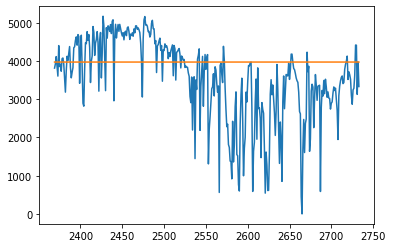

In [ ]:
plt.plot(df_insol_test['Total Generation (KWH)'])
plt.plot(df_insol_test['Prediction_Linear'])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures  
poly_regs= PolynomialFeatures(degree=4)  
x_poly= poly_regs.fit_transform(x)  
lin_reg_2 =LinearRegression()  
lin_reg_2.fit(x_poly, y)

LinearRegression()

In [ ]:
y_pred_2 = lin_reg_2.predict(poly_regs.fit_transform(x_test))

In [ ]:
df_insol_test['Prediction_Poly'] = y_pred_2
df_insol_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Total Generation (KWH)  Insolation  Prediction_Linear  Prediction_Poly
2369                3812.94       5.357        3970.731882      3948.907810
2370                3920.74       5.380        3970.725629      3964.083028
2371                4113.45       5.598        3970.666363      4107.825297
2372                3873.59       5.136        3970.791964      3802.998890
2373                3603.61       4.808        3970.881135      3586.129337
...                     ...         ...                ...              ...
2729                4415.57       6.182        3970.507594      4492.073099
2730                4411.57       6.046        3970.544567      4402.697771
2731                3125.48       4.103        3971.072800      3118.708989
2732                3973.45       5.503        3970.692190      4045.205866
2733                3330.45       4.605        3970.936324      3451.718405

[365 rows x 4 columns]

In [ ]:
print(mean_squared_error(y_pred_2,y_test)**(1/2))  
print(r2_score(y_test,y_pred_2))

460.16698548618143
0.8120410100578709


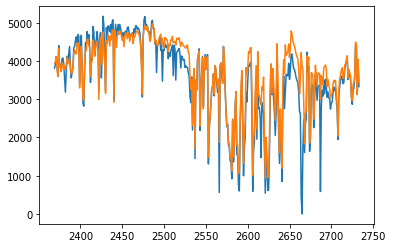

In [ ]:
plt.plot(df_insol_test['Total Generation (KWH)'])
plt.plot(df_insol_test['Prediction_Poly'])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(x,y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(max_depth=5, random_state=0)

In [ ]:
y_pred_3 = regr.predict(x_test)

In [ ]:
df_insol_test['Prediction_Randomforest'] = y_pred_3
df_insol_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Total Generation (KWH)  Insolation  Prediction_Linear  Prediction_Poly  \
2369                3812.94       5.357        3970.731882      3948.907810   
2370                3920.74       5.380        3970.725629      3964.083028   
2371                4113.45       5.598        3970.666363      4107.825297   
2372                3873.59       5.136        3970.791964      3802.998890   
2373                3603.61       4.808        3970.881135      3586.129337   
...                     ...         ...                ...              ...   
2729                4415.57       6.182        3970.507594      4492.073099   
2730                4411.57       6.046        3970.544567      4402.697771   
2731                3125.48       4.103        3971.072800      3118.708989   
2732                3973.45       5.503        3970.692190      4045.205866   
2733                3330.45       4.605        3970.936324      3451.718405   

      Prediction_Randomforest  
2369              3934.722445  
2370              3914.932104  
2371              4197.618549  
2372              3763.787518  
2373              3609.677715  
...                       ...  
2729              4557.192115  
2730              4363.315643  
2731              3108.436994  
2732              4047.952862  
2733              3555.162711  

[365 rows x 5 columns]

In [ ]:
print(mean_squared_error(y_test, y_pred_3)**(1/2))
print(r2_score(y_test, y_pred_3))

460.50959775587734
0.8117610202661398


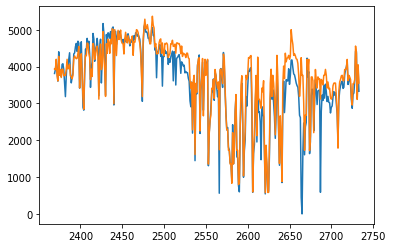

In [ ]:
plt.plot(df_insol_test['Total Generation (KWH)'])
plt.plot(df_insol_test['Prediction_Randomforest'])

#Cloudy (using Linear, Poly and Randmom Forest Regressor)

In [ ]:
df_cloud = df1[['Total Generation (KWH)','Cloudy']]

In [ ]:
df_cloud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3320 entries, 0 to 3319
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Total Generation (KWH)  3320 non-null   object
 1   Cloudy                  3320 non-null   object
dtypes: object(2)
memory usage: 52.0+ KB


In [ ]:
df_cloud_train = df_cloud[0:2369]

In [ ]:
x_c = df_cloud_train['Cloudy'].to_numpy(dtype=float).reshape(-1,1)
y_c = df_cloud_train['Total Generation (KWH)'].to_numpy(dtype=float).reshape(-1,1)

In [ ]:
df_cloud_test = df_cloud[2369:2734]

In [ ]:
x_test_c = df_cloud_test['Cloudy'].to_numpy(dtype=float).reshape(-1,1)
y_test_c = df_cloud_test['Total Generation (KWH)'].to_numpy(dtype=float).reshape(-1,1)

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg_c = LinearRegression()
lin_reg_c.fit(x_c,y_c)

LinearRegression()

In [ ]:
y_pred_c_1 = lin_reg_c.predict(x_test_c)

In [ ]:
df_cloud_test['Prediction_linear'] = y_pred_c_1
df_cloud_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Total Generation (KWH) Cloudy  Prediction_linear
2369                3812.94  False        4189.840300
2370                3920.74  False        4189.840300
2371                4113.45  False        4189.840300
2372                3873.59  False        4189.840300
2373                3603.61  False        4189.840300
...                     ...    ...                ...
2729                4415.57  False        4189.840300
2730                4411.57  False        4189.840300
2731                3125.48   True        2890.786559
2732                3973.45  False        4189.840300
2733                3330.45   True        2890.786559

[365 rows x 3 columns]

In [ ]:
print(mean_squared_error(y_test_c, y_pred_c_1)**(1/2))
print(r2_score(y_test_c, y_pred_c_1))

940.8679004229392
0.21424076825180027


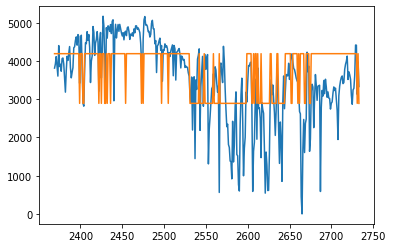

In [ ]:
plt.plot(df_cloud_test['Total Generation (KWH)'])
plt.plot(df_cloud_test['Prediction_linear'])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures  
poly_regs_c= PolynomialFeatures(degree=4)  
x_poly_c= poly_regs_c.fit_transform(x_c)  
lin_reg_c2 =LinearRegression()  
lin_reg_c2.fit(x_poly_c, y_c)

LinearRegression()

In [ ]:
y_pred_c_2 = lin_reg_c2.predict(poly_regs_c.fit_transform(x_test_c))

In [ ]:
df_cloud_test['Prediction_poly'] = y_pred_c_2
df_cloud_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Total Generation (KWH) Cloudy  Prediction_linear  Prediction_poly
2369                3812.94  False        4189.840300      4195.074818
2370                3920.74  False        4189.840300      4195.074818
2371                4113.45  False        4189.840300      4195.074818
2372                3873.59  False        4189.840300      4195.074818
2373                3603.61  False        4189.840300      4195.074818
...                     ...    ...                ...              ...
2729                4415.57  False        4189.840300      4195.074818
2730                4411.57  False        4189.840300      4195.074818
2731                3125.48   True        2890.786559      2865.074818
2732                3973.45  False        4189.840300      4195.074818
2733                3330.45   True        2890.786559      2865.074818

[365 rows x 4 columns]

In [ ]:
print(mean_squared_error(y_test_c, y_pred_c_2)**(1/2))
print(r2_score(y_test_c, y_pred_c_2))

940.9171705740488
0.21415847085438378


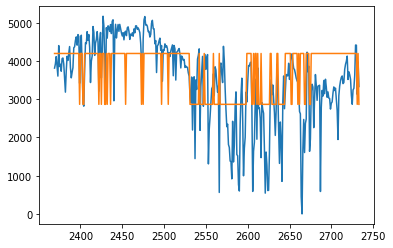

In [ ]:
plt.plot(df_cloud_test['Total Generation (KWH)'])
plt.plot(df_cloud_test['Prediction_poly'])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regr_c = RandomForestRegressor(max_depth=5, random_state=0)
regr_c.fit(x_c,y_c)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(max_depth=5, random_state=0)

In [ ]:
y_pred_c_3 = regr_c.predict(x_test_c)

In [ ]:
df_cloud_test['Prediction_randomforest'] = y_pred_c_3
df_cloud_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Total Generation (KWH) Cloudy  Prediction_linear  Prediction_poly  \
2369                3812.94  False        4189.840300      4195.074818   
2370                3920.74  False        4189.840300      4195.074818   
2371                4113.45  False        4189.840300      4195.074818   
2372                3873.59  False        4189.840300      4195.074818   
2373                3603.61  False        4189.840300      4195.074818   
...                     ...    ...                ...              ...   
2729                4415.57  False        4189.840300      4195.074818   
2730                4411.57  False        4189.840300      4195.074818   
2731                3125.48   True        2890.786559      2865.074818   
2732                3973.45  False        4189.840300      4195.074818   
2733                3330.45   True        2890.786559      2865.074818   

      Prediction_randomforest  
2369              4189.064912  
2370              4189.064912  
2371              4189.064912  
2372              4189.064912  
2373              4189.064912  
...                       ...  
2729              4189.064912  
2730              4189.064912  
2731              2897.553367  
2732              4189.064912  
2733              2897.553367  

[365 rows x 5 columns]

In [ ]:
print(mean_squared_error(y_test_c, y_pred_c_3)**(1/2))
print(r2_score(y_test_c, y_pred_c_3))

941.0096409821045
0.21400400315013235


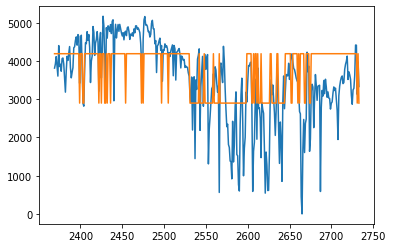

In [ ]:
plt.plot(df_cloud_test['Total Generation (KWH)'])
plt.plot(df_cloud_test['Prediction_randomforest'])

#Cloudy + Insolation (using Linear, Poly and Randmom Forest Regressor)

In [ ]:
df_comb = df1[['Total Generation (KWH)','Insolation','Cloudy']]
df_comb

Total Generation (KWH) Insolation Cloudy
0                      3218        NaN  False
1                      3633        NaN  False
2                      4377        NaN  False
3                      4625        NaN  False
4                       648        NaN  False
...                     ...        ...    ...
3315                2052.94      2.485  False
3316                2605.47      3.225  False
3317                2515.78      3.065  False
3318                2578.53      3.243  False
3319                2923.18      3.709  False

[3320 rows x 3 columns]

In [ ]:
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3320 entries, 0 to 3319
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Total Generation (KWH)  3320 non-null   object
 1   Insolation              2549 non-null   object
 2   Cloudy                  3320 non-null   object
dtypes: object(3)
memory usage: 77.9+ KB


In [ ]:
avg = df_comb.drop([426,1083,796,748]).mean()

In [ ]:
df_comb['Insolation'] = df_comb['Insolation'].fillna(avg[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_comb_train = df_comb[0:2369]

In [ ]:
x_cb = df_comb_train[['Insolation','Cloudy']]
y_cb = df_comb_train['Total Generation (KWH)'].to_numpy(dtype=float).reshape(-1,1)

In [ ]:
df_comb_test = df_comb[2369:2734]
df_comb_test

Total Generation (KWH)  Insolation Cloudy
2369                3812.94       5.357  False
2370                3920.74       5.380  False
2371                4113.45       5.598  False
2372                3873.59       5.136  False
2373                3603.61       4.808  False
...                     ...         ...    ...
2729                4415.57       6.182  False
2730                4411.57       6.046  False
2731                3125.48       4.103   True
2732                3973.45       5.503  False
2733                3330.45       4.605   True

[365 rows x 3 columns]

In [ ]:
x_test_cb = df_comb_test[['Insolation','Cloudy']]
y_test_cb = df_comb_test['Total Generation (KWH)'].to_numpy(dtype=float).reshape(-1,1)

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg_cb = LinearRegression()
lin_reg_cb.fit(x_cb,y_cb)

LinearRegression()

In [ ]:
y_pred_cb_1 = lin_reg_cb.predict(x_test_cb)

In [ ]:
df_comb_test["Prediction_linear"] = y_pred_cb_1
df_comb_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Total Generation (KWH)  Insolation Cloudy  Prediction_linear
2369                3812.94       5.357  False        4190.885154
2370                3920.74       5.380  False        4190.877779
2371                4113.45       5.598  False        4190.807876
2372                3873.59       5.136  False        4190.956018
2373                3603.61       4.808  False        4191.061192
...                     ...         ...    ...                ...
2729                4415.57       6.182  False        4190.620615
2730                4411.57       6.046  False        4190.664224
2731                3125.48       4.103   True        2891.510163
2732                3973.45       5.503  False        4190.838338
2733                3330.45       4.605   True        2891.349195

[365 rows x 4 columns]

In [ ]:
print(mean_squared_error(y_pred_cb_1,y_test_cb)**(1/2))
print(r2_score(y_test_cb,y_pred_cb_1))

941.3894101530777
0.213369456449921


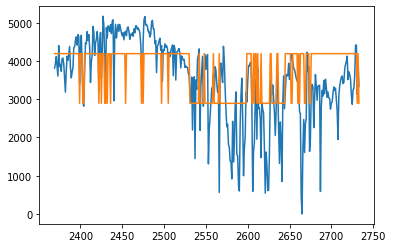

In [ ]:
plt.plot(df_comb_test['Total Generation (KWH)'])
plt.plot(df_comb_test['Prediction_linear'])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures  
poly_regs_cb= PolynomialFeatures(degree=4)  
x_poly_cb= poly_regs_cb.fit_transform(x_cb)  
lin_reg_cb2 =LinearRegression()  
lin_reg_cb2.fit(x_poly_cb, y_cb)

LinearRegression()

In [ ]:
y_pred_cb_2 = lin_reg_cb2.predict(poly_regs_cb.fit_transform(x_test_cb))

In [ ]:
df_comb_test['Prediction_poly'] = y_pred_cb_2
df_comb_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Total Generation (KWH)  Insolation Cloudy  Prediction_linear  \
2369                3812.94       5.357  False        4190.885154   
2370                3920.74       5.380  False        4190.877779   
2371                4113.45       5.598  False        4190.807876   
2372                3873.59       5.136  False        4190.956018   
2373                3603.61       4.808  False        4191.061192   
...                     ...         ...    ...                ...   
2729                4415.57       6.182  False        4190.620615   
2730                4411.57       6.046  False        4190.664224   
2731                3125.48       4.103   True        2891.510163   
2732                3973.45       5.503  False        4190.838338   
2733                3330.45       4.605   True        2891.349195   

      Prediction_poly  
2369      4011.196246  
2370      4027.639934  
2371      4183.394502  
2372      3853.088115  
2373      3618.076621  
...               ...  
2729      4599.727714  
2730      4502.892705  
2731      2841.494360  
2732      4115.542708  
2733      3113.588035  

[365 rows x 5 columns]

In [ ]:
print(mean_squared_error(y_test_cb, y_pred_cb_2)**(1/2))
print(r2_score(y_test_cb, y_pred_cb_2))

481.2626377568946
0.7944126055999423


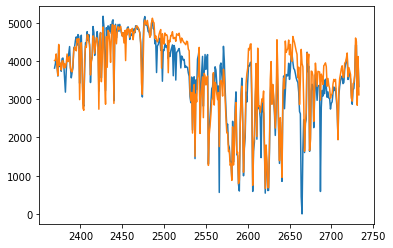

In [ ]:
plt.plot(df_comb_test['Total Generation (KWH)'])
plt.plot(df_comb_test['Prediction_poly'])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regr_cb = RandomForestRegressor(max_depth=6, random_state=0)
regr_cb.fit(x_cb,y_cb)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(max_depth=6, random_state=0)

In [ ]:
y_pred_cb_3 = regr_cb.predict(x_test_cb)

In [ ]:
df_comb_test['Prediction_randomforest'] = y_pred_cb_3
df_comb_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Total Generation (KWH)  Insolation Cloudy  Prediction_linear  \
2369                3812.94       5.357  False        4190.885154   
2370                3920.74       5.380  False        4190.877779   
2371                4113.45       5.598  False        4190.807876   
2372                3873.59       5.136  False        4190.956018   
2373                3603.61       4.808  False        4191.061192   
...                     ...         ...    ...                ...   
2729                4415.57       6.182  False        4190.620615   
2730                4411.57       6.046  False        4190.664224   
2731                3125.48       4.103   True        2891.510163   
2732                3973.45       5.503  False        4190.838338   
2733                3330.45       4.605   True        2891.349195   

      Prediction_poly  Prediction_randomforest  
2369      4011.196246              3960.001046  
2370      4027.639934              3936.059793  
2371      4183.394502              4222.366626  
2372      3853.088115              3821.916045  
2373      3618.076621              3733.695226  
...               ...                      ...  
2729      4599.727714              4604.234815  
2730      4502.892705              4401.235238  
2731      2841.494360              3065.422816  
2732      4115.542708              4102.944791  
2733      3113.588035              3325.024252  

[365 rows x 6 columns]

In [ ]:
print(mean_squared_error(y_test_cb, y_pred_cb_3)**(1/2))
print(r2_score(y_test_cb, y_pred_cb_3))

473.90327924387367
0.8006521225042964


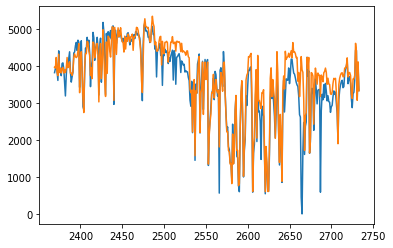

In [ ]:
plt.plot(df_comb_test['Total Generation (KWH)'])
plt.plot(df_comb_test['Prediction_randomforest'])